# Poromechanical applications

This tutorial explains how to run poromechanical verications. We show two examples:

- A non-linear poromechanical model using a manufactured solution.
- Mandel's consolidation problem based on the Biot equations of poroelasticity.

## Non-linear poromechanical model

Let us first import the mixer class `ManuPoroMechNoFrac`.

In [11]:
import porepy as pp
import numpy as np

from porepy.applications.verification_setups.manu_poromech_nofrac import (
    ManufacturedNonlinearPoromechanicsNoFrac2d as ManuSetup,

)

Now, we set the verification setup parameters. For this particular example, we set
`material_constants` containing the values of the fluid and solid physical constants,
a `time_manager` object, and select as `manufactured_solution` a parabolic profile
for both pressure and displacement. In addition, we will use a mesh size of `0.03
[m]` and plot the results of the veritication.

In [14]:
# Set material constants
solid = pp.SolidConstants(
    {
        "biot_coefficient": 0.65,  # [-]
        "lame_lambda": 5e9,  # [Pa]
        "permeability": 1e-9,  # [m^2]
        "porosity": 0.34, # [-] (Reference value)
        "shear_modulus": 3e9,  # [Pa]
    }
)
fluid = pp.FluidConstants(
    {
        "compressibility": 45.8e-11,  # [Pa^{-1}]
        "density": 1e3,  # [kg * m^{-3}]  (Reference value)
        "viscosity": 1e-3,  # [Pa * s]
    }
)
material_constants = {"solid": solid, "fluid": fluid}

# Set mesh arguments
mesh_arguments = {"mesh_size_frac": 0.1, "mesh_size_bound": 0.1}

# Create time manager object
time_manager = pp.TimeManager(
    schedule=[0, pp.HOUR],
    dt_init=pp.MINUTE,
    constant_dt=True
)

# Finally, create the params dictionary
params = {
    "manufactured_solution": "parabolic",
    "material_constants": material_constants,
    "mesh_arguments": mesh_arguments,
    "time_manager": time_manager,
    "plot_results": True,
}

We are now in position to run the verification setup. To do this, we create an
instance of the `ManuSetup` class and pass the `params` as a parameter. We then use
the method `run_time_dependent_model` to run the model.

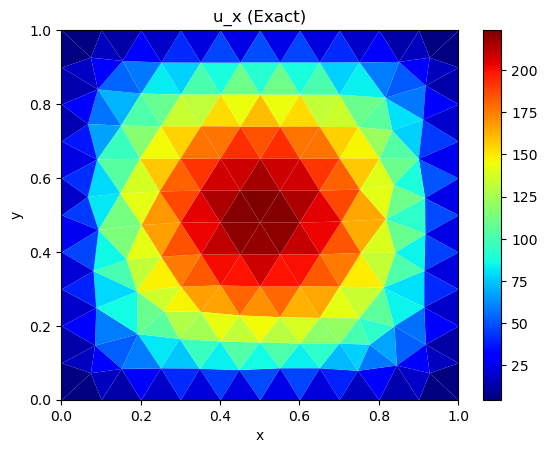

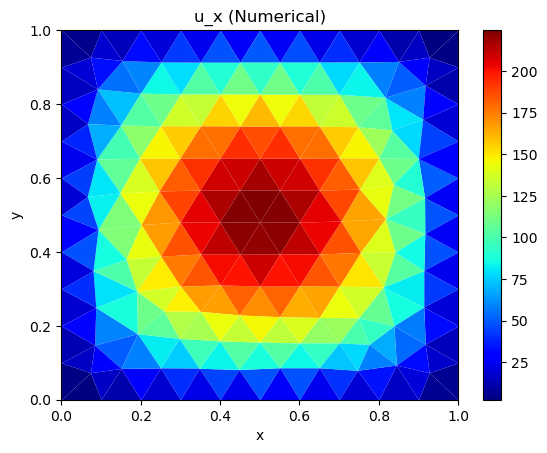

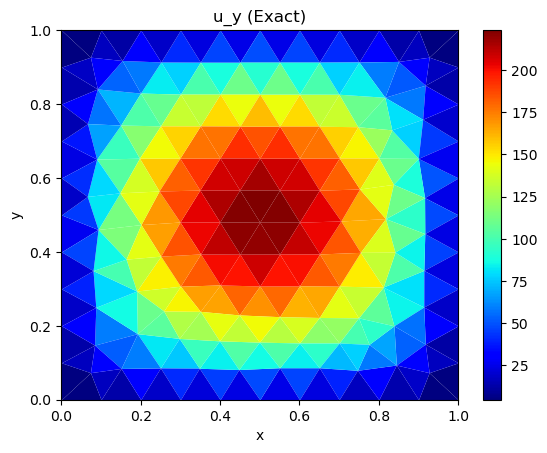

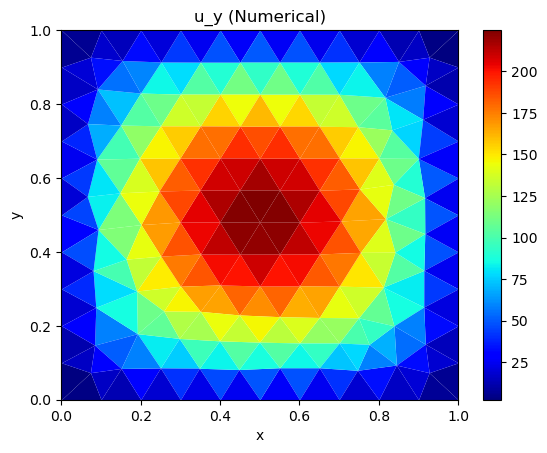

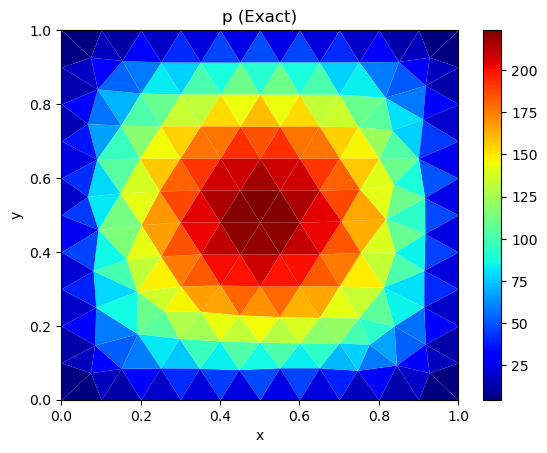

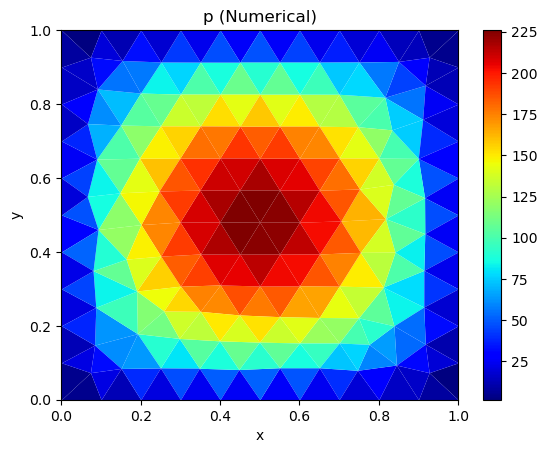

Simulation finished in 9 seconds.


In [13]:
from time import time
tic = time()
setup = ManuSetup(params=params)
pp.run_time_dependent_model(model=setup, params=params)
toc = time()
print(f"Simulation finished in {round(toc - tic)} seconds.")